In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from surprise import SVD, BaselineOnly, SVDpp, NMF, SlopeOne, CoClustering, Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import accuracy
from sklearn.model_selection import train_test_split
from surprise import dump
## for data
import pandas as pd
import numpy as np
import re
from datetime import datetime
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for machine learning
from sklearn import metrics, preprocessing
## for deep learning
from tensorflow.keras import models, layers, utils

import warnings; warnings.simplefilter('ignore')

In [2]:
movies = pd.read_csv('movies_metadata.csv')
print(movies.shape)
movies.head()

(45466, 24)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [3]:
movies['genres'] = movies['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [4]:
movies['year'] = pd.to_datetime(movies['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [5]:
links_small = pd.read_csv('links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]
links_small['tmdbId'] = links_small['tmdbId'].astype('int')

In [6]:
ratings = pd.read_csv('ratings_small.csv')

In [7]:
links_small.head()

,movieId,imdbId,tmdbId
0,1,114709,862
1,2,113497,8844
2,3,113228,15602
3,4,114885,31357
4,5,113041,11862


In [8]:
movies = movies.drop([19730, 29503, 35587])

In [9]:
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')

In [10]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
movies['id'] = movies['id'].astype('int')

In [11]:
movies.shape

(45463, 25)

In [12]:
movies = movies.merge(credits, on='id')
movies = movies.merge(keywords, on='id')

In [13]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,year,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [14]:
smd = movies[movies['id'].isin(links_small['tmdbId'])]
smd.shape

(9219, 28)

In [15]:
smd = smd.merge(links_small, left_on='id', right_on='tmdbId')

In [16]:
smd

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,video,vote_average,vote_count,year,cast,crew,keywords,movieId,imdbId,tmdbId
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,False,7.7,5415.0,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",1,114709,862
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,False,6.9,2413.0,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",2,113497,8844
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,False,6.5,92.0,1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",3,113228,15602
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,False,6.1,34.0,1995,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...",4,114885,31357
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,False,5.7,173.0,1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",5,113041,11862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9214,False,NaN,8000000,[Drama],NaN,159550,tt0255313,en,The Last Brickmaker in America,A man must cope with the loss of his wife and ...,...,False,7.0,1.0,2001,"[{'cast_id': 1, 'character': 'Henry Cobb', 'cr...","[{'credit_id': '544475aac3a36819fb000578', 'de...","[{'id': 6054, 'name': 'friendship'}, {'id': 20...",161944,255313,159550
9215,False,NaN,1000000,"[Thriller, Romance]",NaN,392572,tt5165344,hi,रुस्तम,"Rustom Pavri, an honourable officer of the Ind...",...,False,7.3,25.0,2016,"[{'cast_id': 0, 'character': 'Rustom Pavri', '...","[{'credit_id': '5951baf692514129c4016600', 'de...","[{'id': 10540, 'name': 'bollywood'}]",162542,5165344,392572
9216,False,NaN,15050000,"[Adventure, Drama, History, Romance]",NaN,402672,tt3859980,hi,Mohenjo Daro,"Village lad Sarman is drawn to big, bad Mohenj...",...,False,6.7,26.0,2016,"[{'cast_id': 0, 'character': 'Sarman', 'credit...","[{'credit_id': '57cd5d3592514179d50018e8', 'de...","[{'id': 10540, 'name': 'bollywood'}]",162672,3859980,402672
9217,False,NaN,15000000,"[Action, Adventure, Drama, Horror, Science Fic...",NaN,315011,tt4262980,ja,シン・ゴジラ,From the mind behind Evangelion comes a hit la...,...,False,6.6,152.0,2016,"[{'cast_id': 4, 'character': 'Rando Yaguchi : ...","[{'credit_id': '560892fa92514177550018b2', 'de...","[{'id': 1299, 'name': 'monster'}, {'id': 7671,...",163056,4262980,315011


In [17]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

In [18]:
dtf_products = smd[['movieId','title','year', 'genres','popularity']]

In [19]:
dtf_products

,movieId,title,year,genres,popularity
0,1,Toy Story,1995,"[Animation, Comedy, Family]",21.946943
1,2,Jumanji,1995,"[Adventure, Fantasy, Family]",17.015539
2,3,Grumpier Old Men,1995,"[Romance, Comedy]",11.7129
3,4,Waiting to Exhale,1995,"[Comedy, Drama, Romance]",3.859495
4,5,Father of the Bride Part II,1995,[Comedy],8.387519
...,...,...,...,...,...
9214,161944,The Last Brickmaker in America,2001,[Drama],0.038998
9215,162542,Rustom,2016,"[Thriller, Romance]",7.333139
9216,162672,Mohenjo Daro,2016,"[Adventure, Drama, History, Romance]",1.423358
9217,163056,Shin Godzilla,2016,"[Action, Adventure, Drama, Horror, Science Fic...",9.285519


In [20]:
dtf_users = ratings

In [21]:
dtf_products = dtf_products[~dtf_products["genres"].isna()]
dtf_products["product"] = range(0,len(dtf_products))
dtf_products["name"] = dtf_products["title"].apply(lambda x: re.sub("[\(\[].*?[\)\]]", "", x).strip())
dtf_products["year"] = dtf_products["year"].astype('int')
dtf_products["year"] = dtf_products["year"].fillna(9999)
dtf_products["old"] = dtf_products["year"].apply(lambda x: 1 if x < 2000 else 0)

In [22]:
dtf_products

,movieId,title,year,genres,popularity,product,name,old
0,1,Toy Story,1995,"[Animation, Comedy, Family]",21.946943,0,Toy Story,1
1,2,Jumanji,1995,"[Adventure, Fantasy, Family]",17.015539,1,Jumanji,1
2,3,Grumpier Old Men,1995,"[Romance, Comedy]",11.7129,2,Grumpier Old Men,1
3,4,Waiting to Exhale,1995,"[Comedy, Drama, Romance]",3.859495,3,Waiting to Exhale,1
4,5,Father of the Bride Part II,1995,[Comedy],8.387519,4,Father of the Bride Part II,1
...,...,...,...,...,...,...,...,...
9214,161944,The Last Brickmaker in America,2001,[Drama],0.038998,9214,The Last Brickmaker in America,0
9215,162542,Rustom,2016,"[Thriller, Romance]",7.333139,9215,Rustom,0
9216,162672,Mohenjo Daro,2016,"[Adventure, Drama, History, Romance]",1.423358,9216,Mohenjo Daro,0
9217,163056,Shin Godzilla,2016,"[Action, Adventure, Drama, Horror, Science Fic...",9.285519,9217,Shin Godzilla,0


In [23]:
dtf_users["user"] = dtf_users["userId"].apply(lambda x: x-1)
dtf_users["timestamp"] = dtf_users["timestamp"].apply(lambda x: datetime.fromtimestamp(x))
dtf_users["daytime"] = dtf_users["timestamp"].apply(lambda x: 1 if 6<int(x.strftime("%H"))<20 else 0)
dtf_users["weekend"] = dtf_users["timestamp"].apply(lambda x: 1 if x.weekday() in [5,6] else 0)
dtf_users = dtf_users.merge(dtf_products[["movieId","product"]], how="left")
dtf_users = dtf_users.rename(columns={"rating":"y"})

In [24]:
dtf_users

,userId,movieId,y,timestamp,user,daytime,weekend,product
0,1,31,2.5,2009-12-14 09:52:24,0,1,0,30.0
1,1,1029,3.0,2009-12-14 09:52:59,0,1,0,851.0
2,1,1061,3.0,2009-12-14 09:53:02,0,1,0,877.0
3,1,1129,2.0,2009-12-14 09:53:05,0,1,0,924.0
4,1,1172,4.0,2009-12-14 09:53:25,0,1,0,948.0
...,...,...,...,...,...,...,...,...
100311,671,6268,2.5,2003-10-08 09:16:10,670,1,0,4599.0
100312,671,6269,4.0,2003-10-03 09:46:41,670,1,0,4600.0
100313,671,6365,4.0,2003-12-09 10:26:03,670,1,0,4651.0
100314,671,6385,2.5,2003-12-09 21:21:03,670,0,0,4664.0


In [25]:
dtf_products = dtf_products[["product","name","old","genres"]].set_index("product")
dtf_users = dtf_users[["user","product","daytime","weekend","y"]]

In [26]:
dtf_users

,user,product,daytime,weekend,y
0,0,30.0,1,0,2.5
1,0,851.0,1,0,3.0
2,0,877.0,1,0,3.0
3,0,924.0,1,0,2.0
4,0,948.0,1,0,4.0
...,...,...,...,...,...
100311,670,4599.0,1,0,2.5
100312,670,4600.0,1,0,4.0
100313,670,4651.0,1,0,4.0
100314,670,4664.0,0,0,2.5


In [27]:
dtf_context = dtf_users[["user","product","daytime","weekend"]]

In [28]:
dtf_users.dtypes 

user         int64
product    float64
daytime      int64
weekend      int64
y          float64
dtype: object

In [29]:
dtf_products.dtypes

name      object
old        int64
genres    object
dtype: object

In [30]:
tags = [dtf_products["genres"].explode().unique()]
columns = list(set([i for lst in tags for i in lst]))
for col in columns:
    dtf_products[col] = dtf_products["genres"].apply(lambda x: 1 if col in x else 0)

In [31]:
dtf_products

,name,old,genres,NaN,TV Movie,Thriller,Music,Fantasy,Adventure,Horror,...,Western,Foreign,Documentary,Family,Drama,Action,Comedy,Crime,Science Fiction,War
product,,,,,,,,,,,,,,,,,,,,,
0,Toy Story,1,"[Animation, Comedy, Family]",0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,Jumanji,1,"[Adventure, Fantasy, Family]",0,0,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0
2,Grumpier Old Men,1,"[Romance, Comedy]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,Waiting to Exhale,1,"[Comedy, Drama, Romance]",0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,Father of the Bride Part II,1,[Comedy],0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9214,The Last Brickmaker in America,0,[Drama],0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9215,Rustom,0,"[Thriller, Romance]",0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9216,Mohenjo Daro,0,"[Adventure, Drama, History, Romance]",0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


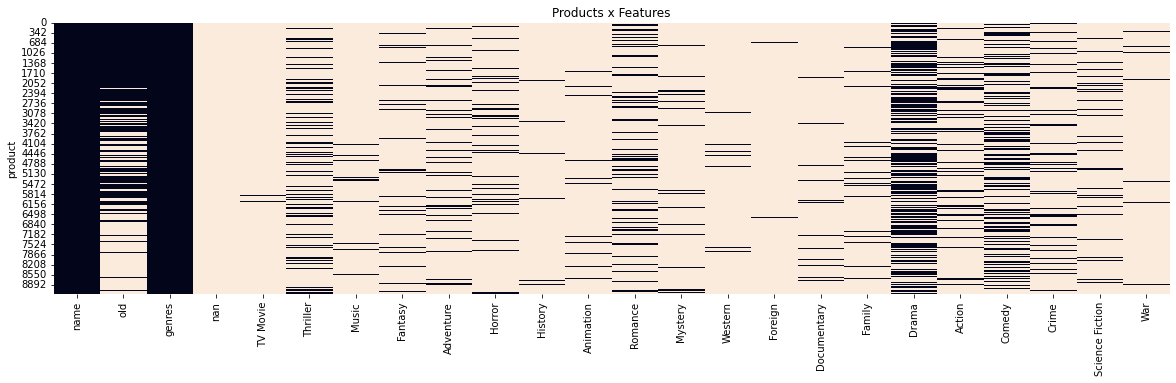

In [32]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(dtf_products==0, vmin=0, vmax=1, cbar=False, ax=ax).set_title("Products x Features")
plt.show()

In [33]:
tmp = dtf_users.copy()
dtf_users = tmp.pivot_table(index="user", columns="product", values="y")
missing_cols = list(set(dtf_products.index) - set(dtf_users.columns))
for col in missing_cols:
    dtf_users[col] = np.nan
dtf_users = dtf_users[sorted(dtf_users.columns)]

In [34]:
dtf_users

product,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,9209.0,9210.0,9211.0,9212.0,9213.0,9214.0,9215.0,9216.0,9217.0,9218.0
user,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


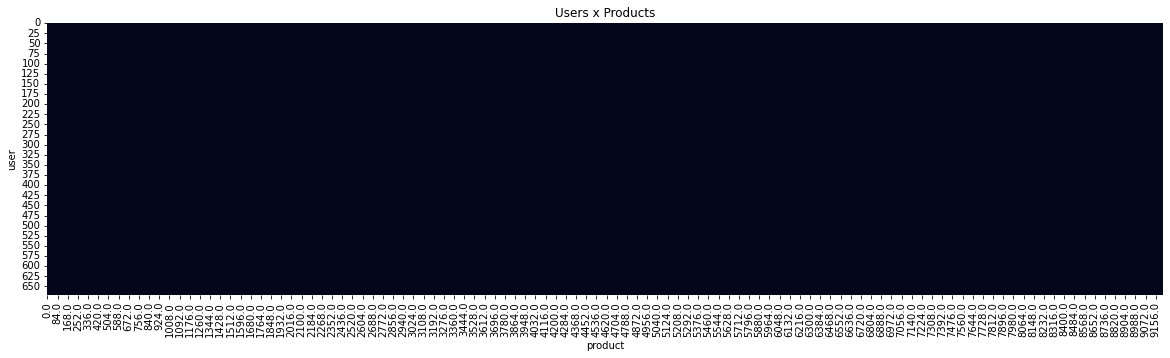

In [35]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(dtf_users==0, vmin=0, vmax=1, cbar=False, ax=ax).set_title("Users x Products")
plt.show()

In [36]:
dtf_users = pd.DataFrame(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(dtf_users.values), 
columns=dtf_users.columns, index=dtf_users.index)

In [37]:
split = int(0.8*dtf_users.shape[1])
dtf_train = dtf_users.loc[:, :split-1]
dtf_test = dtf_users.loc[:, split:]

In [38]:
dtf_train

product,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,7365.0,7366.0,7367.0,7368.0,7369.0,7370.0,7371.0,7372.0,7373.0,7374.0
user,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.888889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,NaN,NaN,NaN,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# Select a user
i = 1
train = dtf_train.iloc[i].to_frame(name="y")
test = dtf_test.iloc[i].to_frame(name="y")
# add all the test products but hide the y
tmp = test.copy()
tmp["y"] = np.nan
train = train.append(tmp)

In [40]:
test

,y
product,
7375.0,NaN
7376.0,NaN
7377.0,NaN
7378.0,NaN
7379.0,NaN
...,...
9214.0,NaN
9215.0,NaN
9216.0,NaN


In [41]:
train

,y
product,
0.0,NaN
1.0,NaN
2.0,NaN
3.0,NaN
4.0,NaN
...,...
9214.0,NaN
9215.0,NaN
9216.0,NaN


In [42]:
# shapes
usr = train[["y"]].fillna(0).values.T
prd = dtf_products.drop(["name","genres"],axis=1).values
print("Users", usr.shape, " x  Products", prd.shape)

Users (1, 9219)  x  Products (9219, 22)


In [43]:
import tensorflow as tf
# usr_ft(users,fatures) = usr(users,products) x prd(products,features)
usr_ft = tf.matmul(usr, prd)
# normalize
weights = usr_ft / tf.reduce_sum(usr_ft, axis=1, keepdims=True)
# rating(users,products) = weights(users,fatures) x prd.T(features,products)
pred = tf.matmul(weights, prd.T)
pred

<tf.Tensor: shape=(1, 9219), dtype=float64, numpy=
array([[0.41715144, 0.39555745, 0.43460344, ..., 0.3045259 , 0.28847141,
        0.00318227]])>

In [44]:
def mean_reciprocal_rank(y_test, predicted):
    score = []
    for product in y_test:
        mrr = 1 / (list(predicted).index(product) + 1) if product in predicted else 0
        score.append(mrr)
    return np.mean(score)

In [45]:
print("user", i)
top = 5
y_test = test.sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)
predicted = test.sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)
true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", mean_reciprocal_rank(y_test, predicted))

user 1


KeyError: 'product'

In [46]:
## Cái code trên nó đang bị lỗi khá là lạ, đấy là khi t embedding cái vector user so với movie ( product ) thì kết quả trả về nó gần như là bị NaN hết nên không đưa ra pred dựa trên tệp test được, tìm hiểu thì t đang thấy khá bế tắc. 